In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import os

# Set up paths
PYTHONPATH = "/global/homes/b/bpb/repos/envnet"
os.environ['PYTHONPATH'] = PYTHONPATH

# Import ENVnet
import sys
sys.path.insert(0, PYTHONPATH)
from envnet.config.build_config import BuildConfig


# Create config
config = BuildConfig()


In [2]:
filename = os.path.join( config.metadata_folder, "toy_network_clustered_spectra-freshconversion.parquet")
df = pd.read_parquet(filename)
df.head()

,original_index,temp_index,rt,count,precursor_mz,sum_frag_intensity,max_frag_intensity,obs,isolated_precursor_mz,filename,...,original_spectrum_intensity_vals,predicted_mass,mass_error,num_datapoints,peak_area,peak_height,mz_centroid,rt_peak,precursor_mz_group,cluster_label
0,2637178,18541,17.313240,6,366.991077,56489.119141,28939.037109,"[3x CO2 + 2 H2O, 3x CO2 + H2O, 3x CO2 + CH4, 2...",367.176880,/global/cfs/cdirs/metatlas/projects/envnet_bui...,...,"[4002.4197, 4128.9062, 4242.9775, 1532.3909, 1...",366.991146,0.000069,3.0,252918.5625,155127.015625,366.991841,18.178020,3516,0
1,2637179,18929,17.313240,6,366.991077,56489.119141,28939.037109,"[3x CO2 + 2 H2O, 3x CO2 + H2O, 3x CO2 + CH4, 2...",367.176880,/global/cfs/cdirs/metatlas/projects/envnet_bui...,...,"[1578.7443, 4128.9062, 4242.9775, 1687.5771, 7...",366.991146,0.000069,3.0,252918.5625,155127.015625,366.991841,18.178020,3516,0
2,2637187,20754,17.726664,5,366.991270,59232.392090,26886.894531,"[3x CO2 + 2 H2O, 3x CO2 + H2O, 3x CO2 + CH4, 2...",367.063110,/global/cfs/cdirs/metatlas/projects/envnet_bui...,...,"[1805.1097, 2455.5818, 4418.872, 4923.537, 437...",366.991146,0.000124,4.0,251996.1875,87366.015625,366.992132,16.835541,3516,0
3,2637188,20264,17.726664,5,366.991270,59232.392090,26886.894531,"[3x CO2 + 2 H2O, 3x CO2 + H2O, 3x CO2 + CH4, 2...",367.063110,/global/cfs/cdirs/metatlas/projects/envnet_bui...,...,"[2199.5366, 15619.891, 4371.914, 1966.9215, 24...",366.991146,0.000124,4.0,251996.1875,87366.015625,366.992132,16.835541,3516,0
4,2637196,3566,4.482925,3,366.991491,4424.157410,2453.390869,"[3x CO2 + 2 H2O, 3x CO2 + CH4, 2x CO2 + 2 H2O]",367.138092,/global/cfs/cdirs/metatlas/projects/envnet_bui...,...,"[4632.2754, 1372.2053, 1301.3274, 695.9485, 81...",366.991832,0.000341,5.0,153948.9375,52096.574219,366.992754,3.604414,3516,0


In [3]:
group_cols = ['cluster_label', 'precursor_mz_group']
# create a index based on identical values in group_cols
g = df.drop_duplicates(subset=group_cols).reset_index()
g.index.name = 'cluster_index'
g.reset_index(drop=False,inplace=True)
cols = group_cols + ['cluster_index']
g = g[cols]

cols = group_cols + ['filename']
cluster_files = pd.merge(df[cols],g,on=group_cols,how='left')
count = cluster_files['cluster_index'].value_counts().to_dict()

cluster_files['count'] = cluster_files['cluster_index'].map(count)
cluster_files = cluster_files[cluster_files['count']>10]
cluster_files.shape

(3384739, 5)

In [4]:
m = pd.pivot_table(cluster_files,index='filename',columns='cluster_index',aggfunc='size',fill_value=0)
m[m>0] = 1
m.shape


(1401, 4742)

In [ ]:
def get_summary(file):
    temp = pd.read_parquet(file.replace('.h5','_deconvoluted.parquet'))
    d = {}
    d['min_rt'] = temp['rt'].min()
    d['max_rt'] = temp['rt'].max()
    d['num_spectra'] = temp.shape[0]
    d['median_rt'] = temp['rt'].median()
    d['filename'] = file
    d['massive'] = file.split('/')[9] if 'MSV0' in file else file.split('/')[7]

    return d

from multiprocessing import Pool

with Pool(processes=20) as pool:
    df = pool.map(get_summary, m.index.tolist())

df = pd.DataFrame(df)
df['basename'] = df['filename'].apply(lambda x: os.path.basename(x))
# put df in the same order as m
df = df.set_index('filename').reindex(m.index.tolist()).reset_index()

df


,filename,min_rt,max_rt,num_spectra,median_rt,massive,basename
0,/global/cfs/cdirs/metatlas/projects/envnet_bui...,1.017633,29.992453,3380,12.973108,MSV000081030,Mtab_FT_012611_07.h5
1,/global/cfs/cdirs/metatlas/projects/envnet_bui...,1.011235,29.991602,3091,13.297557,MSV000081030,Mtab_FT_012611_09.h5
2,/global/cfs/cdirs/metatlas/projects/envnet_bui...,1.002873,29.947830,2565,13.305165,MSV000081030,Mtab_FT_012611_21.h5
3,/global/cfs/cdirs/metatlas/projects/envnet_bui...,1.002473,29.976540,2608,13.264791,MSV000081030,Mtab_FT_012611_22.h5
4,/global/cfs/cdirs/metatlas/projects/envnet_bui...,1.006420,29.927855,2662,13.273118,MSV000081030,Mtab_FT_012611_23.h5
...,...,...,...,...,...,...,...
1396,/global/cfs/cdirs/metatlas/projects/envnet_bui...,1.006795,11.456704,928,3.707473,metatlas,20240212_EB_MdR_109570-002_SacRDelta_20240131_...
1397,/global/cfs/cdirs/metatlas/projects/envnet_bui...,1.005084,11.472619,810,3.549115,metatlas,20240212_EB_MdR_109570-002_SacRDelta_20240131_...
1398,/global/cfs/cdirs/metatlas/projects/envnet_bui...,1.003070,11.499415,864,3.690931,metatlas,20240212_EB_MdR_109570-002_SacRDelta_20240131_...
1399,/global/cfs/cdirs/metatlas/projects/envnet_bui...,1.031394,11.492357,309,4.204278,metatlas,20240212_EB_MdR_109570-002_SacRDelta_20240131_...


<Axes: xlabel='median_rt', ylabel='massive'>

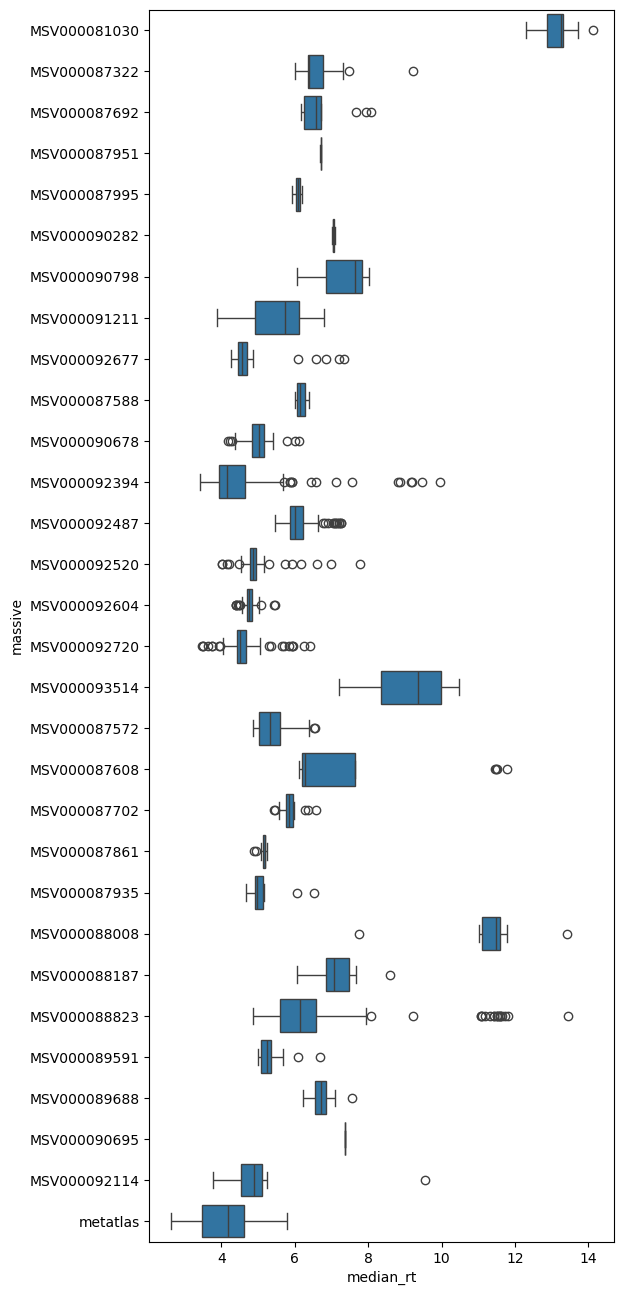

In [20]:
fig,ax = plt.subplots(figsize=(6,16))
import seaborn as sns
sns.boxplot(data=df,y='massive',x='median_rt',ax=ax)

/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


MDS Stress: 75405.94613009797


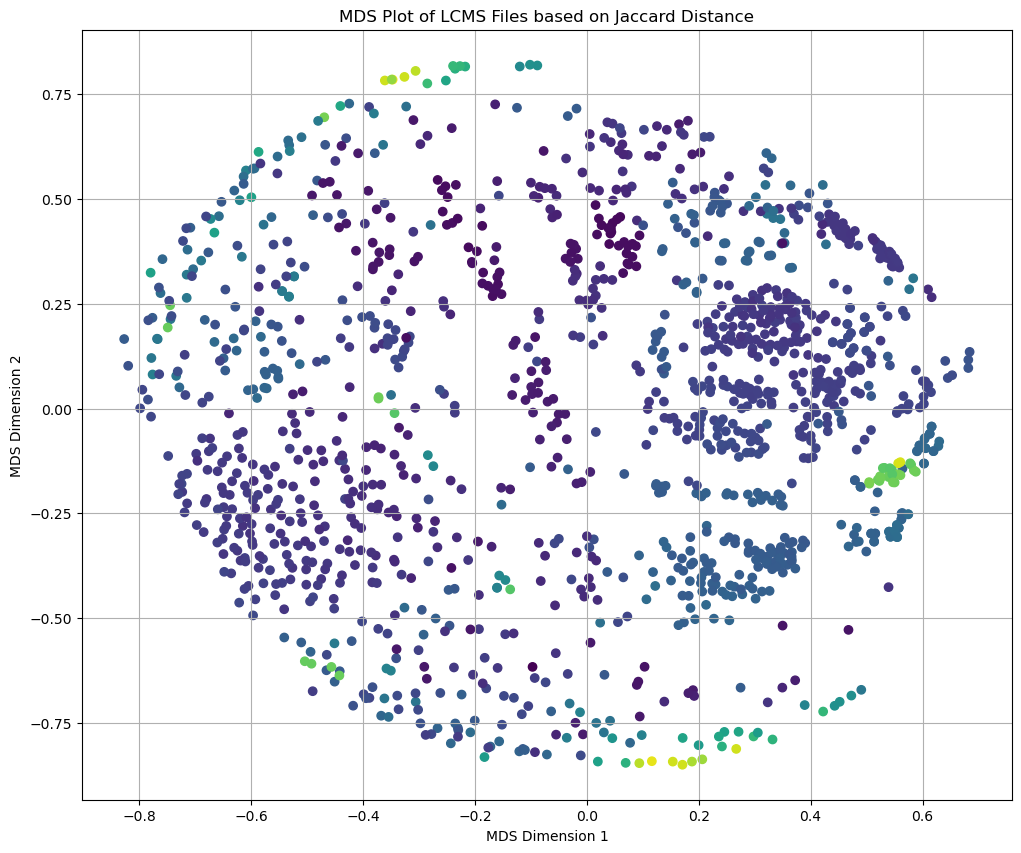

In [ ]:
import numpy as np
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

# Assume 'data_matrix' is your (1400 files x N features) matrix of 1s and 0s.
# Assume 'file_labels' is a list of your 1400 file names.

# Step 1: Calculate the pairwise Jaccard distance matrix.
# This is the same step as before.
jaccard_distances = pdist(m.values, metric='jaccard')

# We need a square matrix for MDS, not the condensed form from pdist.
jaccard_distance_matrix = squareform(jaccard_distances)

# Step 2: Perform Classical MDS.
# We specify n_components=2 for a 2D plot.
# dissimilarity='precomputed' tells MDS we are giving it a distance matrix.
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)

# Fit the MDS model to our distance matrix and get the 2D coordinates.
coordinates = mds.fit_transform(jaccard_distance_matrix)
color_vals = df['median_rt']
# The 'stress' value tells you how well the 2D plot preserves the original distances. Lower is better.
print(f"MDS Stress: {mds.stress_}")


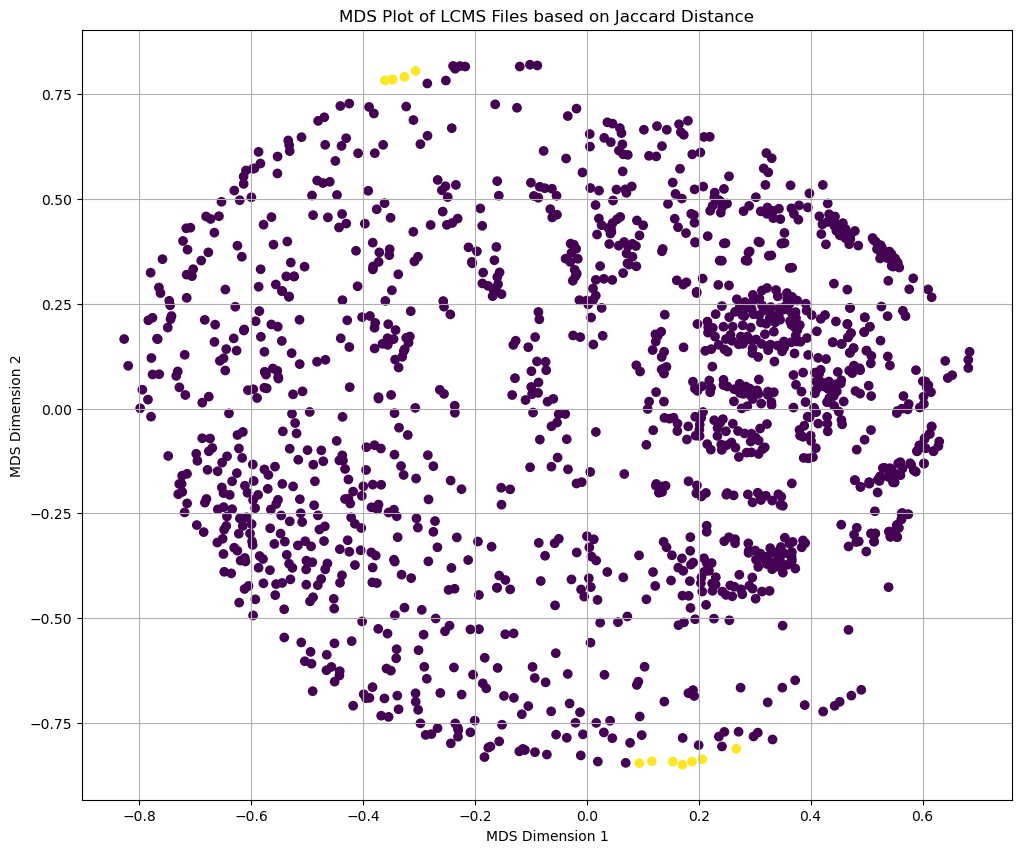

In [15]:

# Step 3: Plot the results.
plt.figure(figsize=(12, 10))
# idx = df['filename'].str.contains("DOM_Interlab-LCMS_Lab024",case=False)
idx = df['filename'].str.contains("mtab",case=False)

scatter = plt.scatter(coordinates[:, 0], coordinates[:, 1], c=idx, cmap='viridis')

# Optional: You can add labels if you have a manageable number of outliers to identify.
# for i, label in enumerate(file_labels):
#     plt.annotate(label, (coordinates[i, 0], coordinates[i, 1]))

plt.title('MDS Plot of LCMS Files based on Jaccard Distance')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.grid(True)
plt.show()

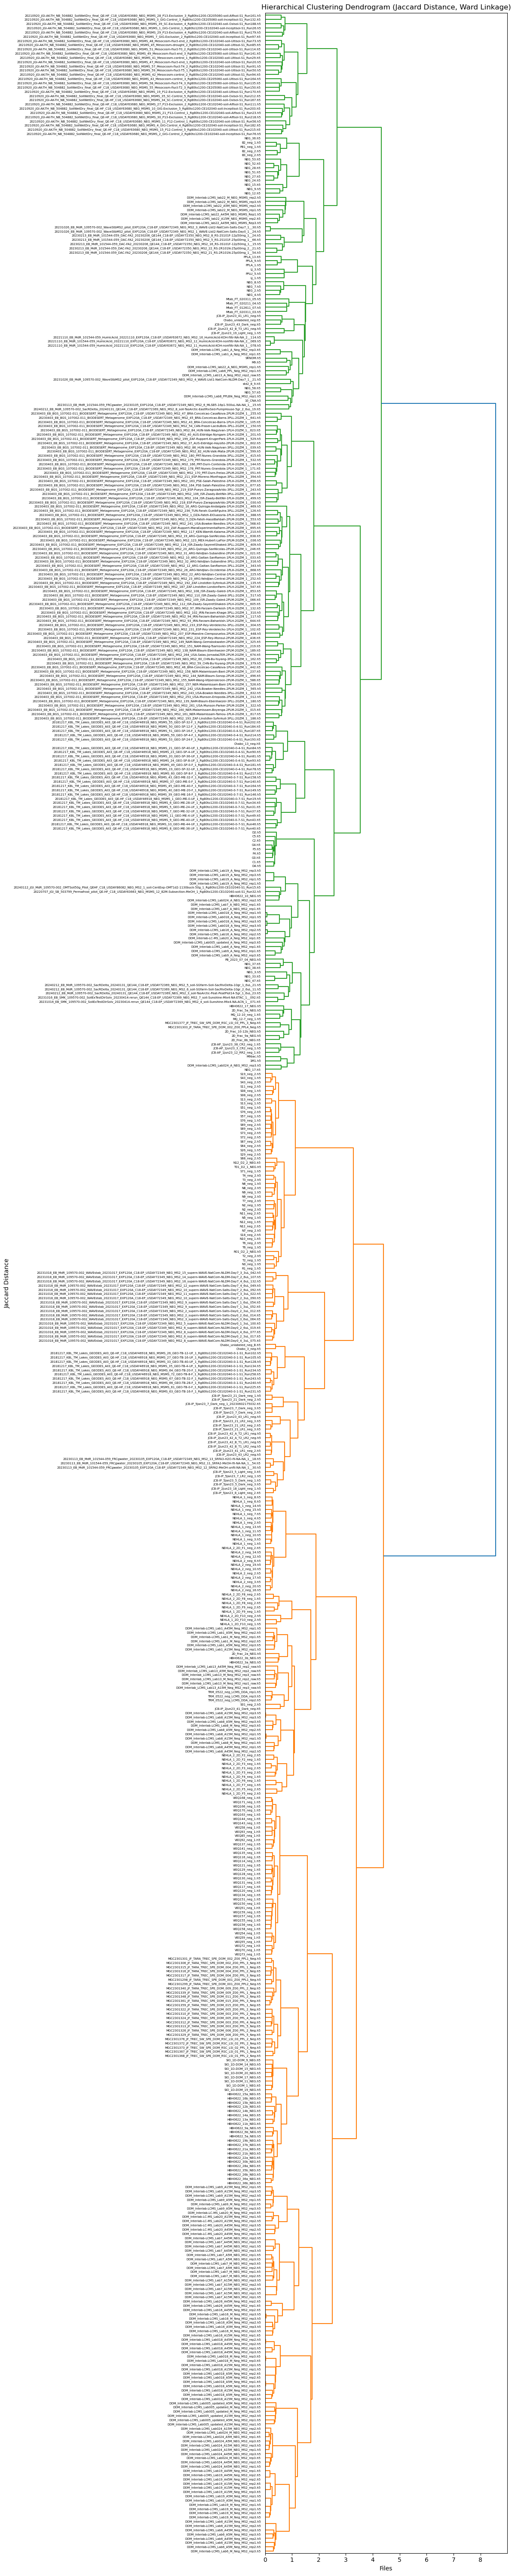

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Assume 'data_matrix' is your numpy array of (files x features) with 1s and 0s.
# Assume 'file_labels' is a list of your file names.

# Step 1: Calculate the pairwise Jaccard distance matrix.
# 'pdist' calculates a condensed distance matrix.
jaccard_distances = pdist(temp.values, metric='jaccard')
file_labels = temp.index.tolist()
file_labels = [os.path.basename(f) for f in file_labels]
# Step 2: Perform hierarchical clustering using the 'ward' linkage method.
linked = linkage(jaccard_distances, method='ward')

# Step 3: Visualize the dendrogram.
plt.figure(figsize=(12, 60))
dendrogram(linked,
           orientation='right',
           labels=file_labels,
           distance_sort='descending',
           show_leaf_counts=True)

plt.title('Hierarchical Clustering Dendrogram (Jaccard Distance, Ward Linkage)')
plt.xlabel('Jaccard Distance')
plt.tight_layout()
plt.show()